In [1]:
!pip install opencv-contrib-python==3.4.2.17
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import math
import cv2
%matplotlib inline

     |████████████████████████████████| 30.6MB 134kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## Helper Functions

In [7]:
def remove_array_from_list(lst, arr):
  """
  Removes first instance of a numpy array encountered in a list.
  If array not encountered, this function does not do anything.
  """
  ind, size = 0, len(lst)
  while ind != size and not np.array_equal(lst[ind], arr):
    ind += 1
  if ind != size:
    lst.pop(ind)

###############################################################################

def newline(p1, p2, segment = True, linestyle = '-', color='cyan', linewidth=7):
  """
  Plots a new line or line segment from points p1 to p2.
  This helper function is a modification of the one from Problem set 2.
  """
  ax = plt.gca()
  xmin, xmax = ax.get_xbound()

  if (p2[0] == p1[0]):
      xmin = xmax = p1[0]
      ymin, ymax = ax.get_ybound()
  else:
      ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
      ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])
    
  if segment:
      l = mlines.Line2D([p1[0], p2[0]], [p1[1], p2[1]], linestyle=linestyle, color=color, linewidth=linewidth)
  else:
      l = mlines.Line2D([xmin, xmax], [ymin, ymax], linestyle=linestyle, color=color, linewidth=linewidth)

  ax.add_line(l)
  return l

###############################################################################

def rotate_and_scale(origin, point, angle = 0, scale = 1):
    """
    Rotate a point clockwise by a given angle (in degrees) around a given origin, and scale it by a given factor.
    """
    theta = math.radians(angle)
    ox, oy = origin[0], origin[1]
    px, py = point[0], point[1]

    qx = ox + np.cos(-theta)*(px-ox) - np.sin(-theta)*(py-oy)
    qy = oy + np.sin(-theta)*(px-ox) + np.cos(-theta)*(py-oy)
    return (ox + scale*(qx-ox), oy + scale*(qy-oy))

###############################################################################

def plot_and_print_results(image, box_corner_list):
  """
  Plots image along with the bounding boxes, accounting for the spill-over as well.
  Also prints the number of instances detected, as well as the vertices of the
  bounding boxes (in anti-clockwise order).
  """
  plt.rcParams['figure.figsize'] = [14.0, 7.0]

  xmin = np.amin([0, np.amin(box_corner_list, axis = (0,1))[0]])
  xmax = np.amax([image.shape[1], np.amax(box_corner_list, axis = (0,1))[0]])
  ymin = np.amin([0, np.amin(box_corner_list, axis = (0,1))[1]])
  ymax = np.amax([image.shape[0], np.amax(box_corner_list, axis = (0,1))[1]])

  plt.xlim([xmin, xmax])
  plt.ylim([ymax, ymin])
  i = 1

  print("Number of instances found: %d\n" % (len(box_corner_list)))
  for detection in box_corner_list:
    print("Bounding box number %d:  %s" % (i, str(tuple([tuple(point) for point in detection]))))
    i = i+1
    newline(detection[0], detection[1])
    newline(detection[1], detection[2])
    newline(detection[2], detection[3])
    newline(detection[3], detection[0])

  plt.imshow(image)
  plt.show()

## Main Task Functions

In [8]:
def create_database(image, descriptor_method = 'sift'):
  """
  Creates database for query lookup, given an image, i.e. returns
  corresponding keypoints and descriptors.
  """
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  if descriptor_method == 'sift':
    desc_type = cv2.xfeatures2d.SIFT_create()
  elif descriptor_method == 'surf':
    desc_type = cv2.xfeatures2d.SURF_create()
  elif descriptor_method == 'orb':
    desc_type = cv2.ORB_create()
  else:
    raise ValueError("Unknown descriptor entered. Please enter sift, surf, or orb.")

  return desc_type.detectAndCompute(gray, None)

###############################################################################

def database_lookup(lookup_keypoint, lookup_descriptor, train_keypoints, train_descriptors, train_shape, ratio_test_coeff = 0.8):
  """
  Enables lookup of SIFT descriptors with created database, and returns parameters
  (i.e. coordinates of bottom left and top right corners) of bounding rectangle.
  """
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

  # Perform the matching between the SIFT descriptors of the training image and the test image
  matches = bf.knnMatch(lookup_descriptor, train_descriptors, 2)

  for m, n in matches:
    if m.distance < ratio_test_coeff*n.distance:
      origin = np.array(lookup_keypoint[0].pt)
      point_c1 = origin + np.array([0, train_shape[0]]) - np.array(train_keypoints[m.trainIdx].pt)
      point_c2 = origin + np.array([train_shape[1], 0]) - np.array(train_keypoints[m.trainIdx].pt)
      angle = lookup_keypoint[0].angle - train_keypoints[m.trainIdx].angle
      scale = lookup_keypoint[0].size/train_keypoints[m.trainIdx].size

      good =[tuple(origin), train_keypoints[m.trainIdx].pt, rotate_and_scale(origin, point_c1, angle = angle, scale = scale),\
                           rotate_and_scale(origin, point_c2, angle = angle, scale = scale)]
    else:
      good = []
  
  return good

###############################################################################

def hough_voting(matches_list, vote_threshold = 5, cluster_size = 25):
  """
  Runs a Hough Transformation clustering algorithm and groups elements of matches_list
  into clusters, on basis of their 4d distance.
  """
  final_instances = []
  for i in range(len(matches_list)):
    current_instances = []
    current_instances.append(matches_list[i])
    fixed = matches_list[i]

    if np.sum([fixed in _ for _ in final_instances]) > 0:
      continue

    for j in range(len(matches_list)):
      if j == i:
        continue
      compare = matches_list[j]
      if np.linalg.norm(np.array(fixed[2]) - np.array(compare[2])) < cluster_size and\
                 np.linalg.norm(np.array(fixed[3]) - np.array(compare[3])) < cluster_size:
        current_instances.append(matches_list[j])

    if len(current_instances) >= vote_threshold:
      final_instances.append(current_instances)

  return final_instances

###############################################################################

def preliminary_boundingbox_corners(test_image, training_image, vote_threshold=5, cluster_size=25):
  """
  Deploys Hough Transformation based clustering to find correct clusters corresponding
  to a valid instance detection. Returns list of corners for all the detections (possibly
  duplicates) of the object of interest.
  """
  train_keypoints, train_descriptors = create_database(training_image, descriptor_method = 'sift')
  test_keypoints, test_descriptors = create_database(test_image, descriptor_method = 'sift')

  # Create a Brute Force Matcher object.
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)
  database_results = []

  for i in range(len(test_keypoints)):
    info = database_lookup(test_keypoints[i:i+1], test_descriptors[i:i+1], train_keypoints, train_descriptors, training_image.shape, 0.8)
    if len(info) > 0:
      database_results.append(info)

  hough_clusters = hough_voting(database_results, vote_threshold=vote_threshold, cluster_size=cluster_size)
  warped_corner_list = []

  for cluster in hough_clusters:
    pts_train = np.float32([point[1] for point in cluster])
    pts_test = np.float32([point[0] for point in cluster])
    affine_matrix, _ = cv2.estimateAffinePartial2D(pts_train, pts_test, method = cv2.RANSAC, ransacReprojThreshold = 3)

    r, c = training_image.shape[:2]
    corners = np.array([[0, 0], [0, r], [c, r], [c, 0]])
    warped_corners =  np.round(np.hstack([corners, np.array([1,1,1,1])[:, np.newaxis]]) @ affine_matrix.T).astype(int)

    warped_corner_list.append(warped_corners)

  return warped_corner_list

###############################################################################

def duplicate_box_remove(warped_corner_list, duplicate_thres):
  """
  Removes duplicate boxes in case hough_voting resulted in multiple detections
  of the same stop sign.
  """
  final_warped_corner_list = []
  while len(warped_corner_list) > 0:
    fixed_cluster = []
    fixed_corner = warped_corner_list[0]

    for compare_corner in warped_corner_list:
      if np.linalg.norm(np.array(fixed_corner) - np.array(compare_corner), ord = 'fro') < duplicate_thres:
        fixed_cluster.append(compare_corner)

    for corner in fixed_cluster:
      remove_array_from_list(warped_corner_list, corner)

    final_warped_corner_list.append(np.mean(fixed_cluster, axis=0).astype(int))
  return final_warped_corner_list

###############################################################################

def instance_level_object_detector(test_path, train_path, vote_threshold=5, sensitivity=10):
  """
  Main function which:
  1. Reads the reference and test images from the given paths
  2. Detects all instances (possibly duplicates) of reference object in the test image,
      by calling `preliminary_boundingbox_corners`
  3. Removes the duplicates, by calling `duplicate_box_remove`
  4. Prints the number of instances along with the coordinates of the corresponding
      bounding boxes, as well as diplay the test image and the bounding boxes enclosing
      the detected instances, by calling `plot_and_print_results`
  """
  training_image = cv2.imread(train_path)
  training_image = cv2.cvtColor(training_image, cv2.COLOR_BGR2RGB)
  test_image = cv2.imread(test_path)
  test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
  
  print("\n**************DETECTING INSTANCES OF REFERENCE IMAGE IN '%s'********************\n" % (test_path))

  cluster_size = sensitivity * np.amin(test_image.shape[:2]) / 100.0
  warped_corner_list = preliminary_boundingbox_corners(test_image, training_image,\
                                                       vote_threshold=vote_threshold, cluster_size=cluster_size)

  final_warped_corner_list = duplicate_box_remove(warped_corner_list, 4*cluster_size)
  plot_and_print_results(test_image, final_warped_corner_list)

  return final_warped_corner_list

## Experiments with Stop Sign Images


***************GIVEN REFERENCE IMAGE***************



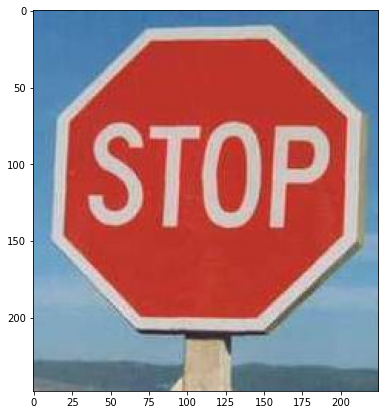


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop1.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((65, 17), (65, 265), (290, 265), (290, 17))


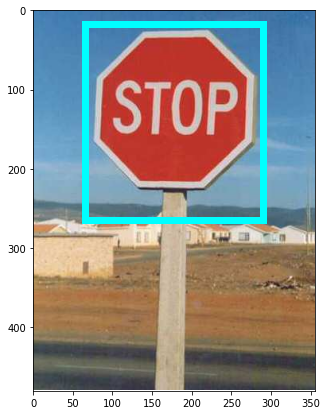


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop2.jpg'********************

Number of instances found: 2

Bounding box number 1:  ((19, 83), (43, 154), (107, 132), (83, 62))
Bounding box number 2:  ((123, -31), (110, 396), (497, 407), (510, -20))


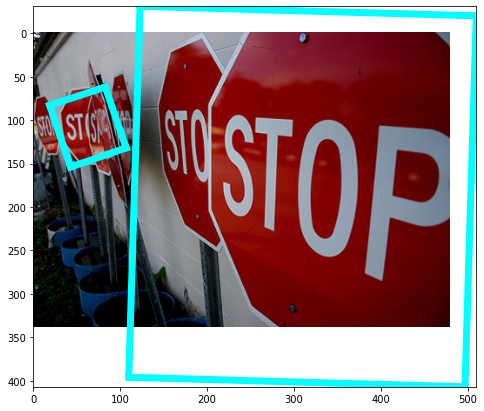


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop3.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((35, 106), (47, 370), (287, 359), (275, 94))


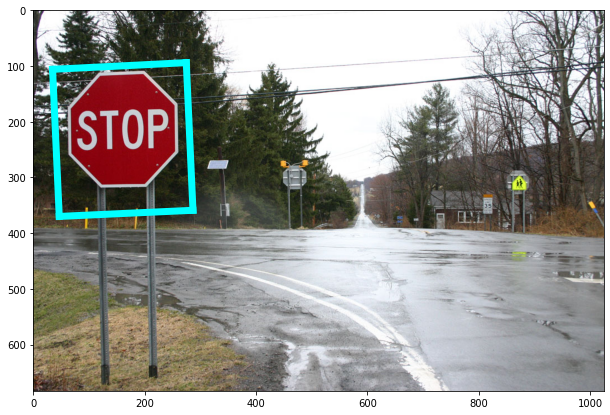


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop4.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((31, 58), (-20, 257), (160, 304), (212, 106))


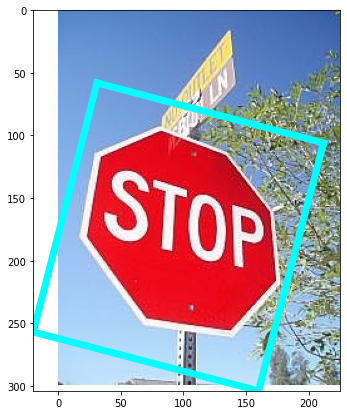


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop5.jpg'********************

Number of instances found: 2

Bounding box number 1:  ((133, 370), (120, 563), (295, 576), (309, 382))
Bounding box number 2:  ((168, 13), (151, 236), (353, 251), (370, 29))


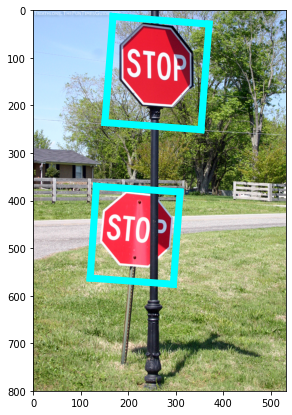

In [17]:
print("\n***************GIVEN REFERENCE IMAGE***************\n")
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.imshow(cv2.cvtColor(cv2.imread('stop-reference.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

_ = instance_level_object_detector('stop1.jpg', 'stop-reference.jpg', vote_threshold=5, sensitivity=10)
_ = instance_level_object_detector('stop2.jpg', 'stop-reference.jpg', vote_threshold=3, sensitivity=15)
_ = instance_level_object_detector('stop3.jpg', 'stop-reference.jpg', vote_threshold=5, sensitivity=10)
_ = instance_level_object_detector('stop4.jpg', 'stop-reference.jpg', vote_threshold=5, sensitivity=20)
_ = instance_level_object_detector('stop5.jpg', 'stop-reference.jpg', vote_threshold=5, sensitivity=10)

## Experiments with Croissant Images


***************GIVEN REFERENCE IMAGE***************



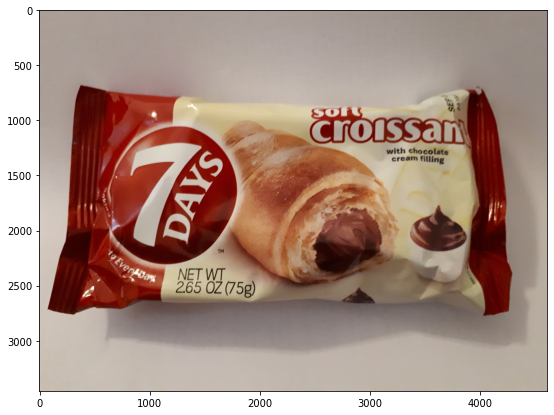


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'croissant1.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((1732, 686), (1396, 1952), (3084, 2400), (3420, 1134))


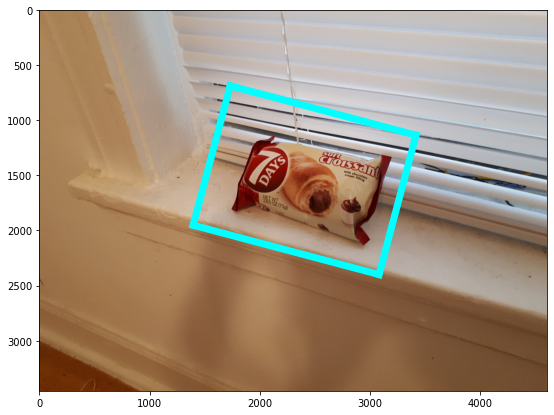


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'croissant2.jpg'********************

Number of instances found: 4

Bounding box number 1:  ((599, 1900), (574, 2945), (1968, 2977), (1992, 1932))
Bounding box number 2:  ((780, 761), (754, 1715), (2026, 1750), (2052, 796))
Bounding box number 3:  ((2349, 1948), (2297, 3028), (3737, 3097), (3789, 2017))
Bounding box number 4:  ((2306, 569), (2235, 1538), (3527, 1632), (3598, 663))


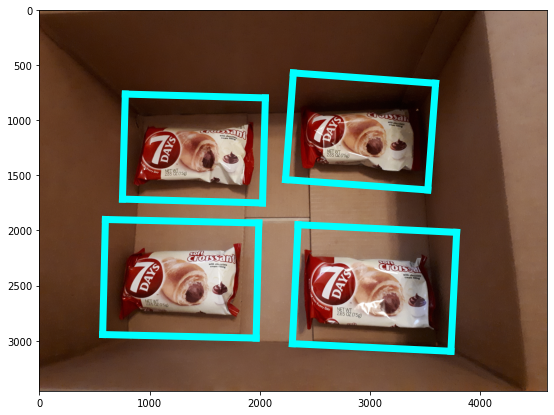


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'croissant3.jpg'********************

Number of instances found: 2

Bounding box number 1:  ((927, 762), (408, 1878), (1895, 2571), (2415, 1455))
Bounding box number 2:  ((2387, 1538), (3069, 2642), (4542, 1733), (3860, 628))


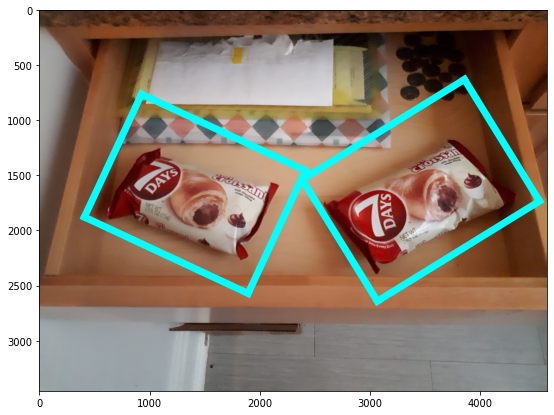


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'croissant4.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((1972, 1668), (2067, 916), (1064, 789), (969, 1541))


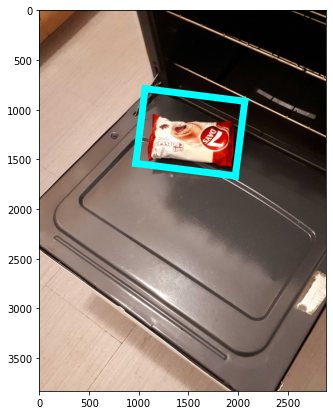


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'croissant5.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((2163, 1156), (1796, 2391), (3442, 2881), (3809, 1647))


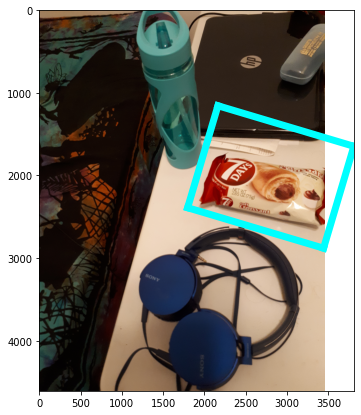

In [6]:
print("\n***************GIVEN REFERENCE IMAGE***************\n")
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.imshow(cv2.cvtColor(cv2.imread('croissant-reference.jpg'), cv2.COLOR_BGR2RGB))
plt.show()

_ = instance_level_object_detector('croissant1.jpg', 'croissant-reference.jpg', vote_threshold=10, sensitivity=10)
_ = instance_level_object_detector('croissant2.jpg', 'croissant-reference.jpg', vote_threshold=10, sensitivity=10)
_ = instance_level_object_detector('croissant3.jpg', 'croissant-reference.jpg', vote_threshold=10, sensitivity=10)
_ = instance_level_object_detector('croissant4.jpg', 'croissant-reference.jpg', vote_threshold=20, sensitivity=10)
_ = instance_level_object_detector('croissant5.jpg', 'croissant-reference.jpg', vote_threshold=20, sensitivity=10)

## Role of Hyperparameters


************************Vote threshold=3, Sensitivity=15************************


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop2.jpg'********************

Number of instances found: 2

Bounding box number 1:  ((19, 83), (43, 154), (107, 132), (83, 62))
Bounding box number 2:  ((123, -31), (110, 396), (497, 407), (510, -20))


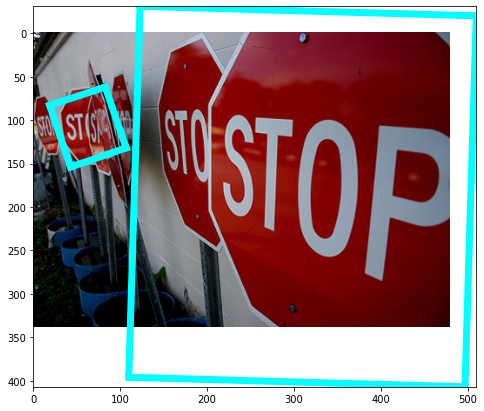


************************Vote threshold=4, Sensitivity=20************************


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop2.jpg'********************

Number of instances found: 3

Bounding box number 1:  ((19, 83), (43, 154), (107, 132), (83, 62))
Bounding box number 2:  ((189, -5), (28, 111), (134, 256), (294, 141))
Bounding box number 3:  ((24, -91), (21, 524), (579, 527), (582, -87))


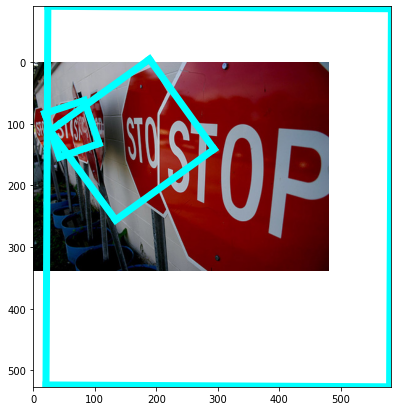


************************Vote threshold=5, Sensitivity=20************************


**************DETECTING INSTANCES OF REFERENCE IMAGE IN 'stop2.jpg'********************

Number of instances found: 1

Bounding box number 1:  ((19, 83), (43, 154), (107, 132), (83, 62))


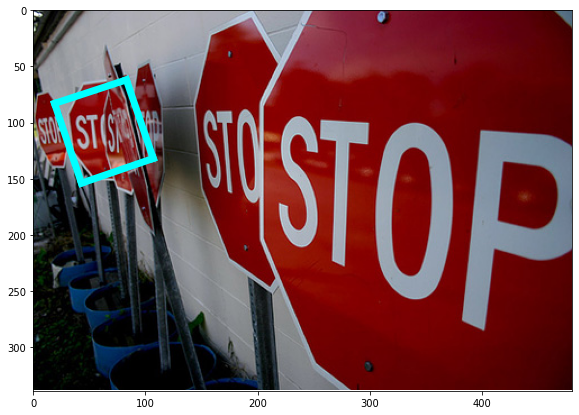

In [18]:
print("\n************************Vote threshold=3, Sensitivity=15************************\n")
_ = instance_level_object_detector('stop2.jpg', 'stop-reference.jpg', vote_threshold=3, sensitivity=15)

print("\n************************Vote threshold=4, Sensitivity=20************************\n")
_ = instance_level_object_detector('stop2.jpg', 'stop-reference.jpg', vote_threshold=4, sensitivity=20)

print("\n************************Vote threshold=5, Sensitivity=20************************\n")
_ = instance_level_object_detector('stop2.jpg', 'stop-reference.jpg', vote_threshold=5, sensitivity=20)